In [1]:
import numpy as np
import scipy.sparse as sps
import scipy.linalg as spl
import matplotlib.pyplot as plt

### Next steps
# try to implement with sparse matrices

In [50]:
##### MODEL PARAMETERS #####

m = 3                              # Angular order
H = 140e3                          # Stratified layer thickness (m)
B = 0.6 * 1.0e-3                   # Radial magnetic field (Tesla)
Np = 0.583                           # dimensionless stratification Np = N/Omega
T = -20.                           # Wave period initial estimate (years)

sectoyear = 365.25 * 24 * 60 * 60
omega0 = 2*np.pi/(T*sectoyear)     # Wave angular frequency initial estimate (rad.s-1)

mu = 4 * np.pi * 1.0e-7            # permeability
sigma = 1.0e6                      # conductivity (S/m)
eta = 1.0 / (mu * sigma);          # diffusivity (m^2/s)
rho = 1.0e4                        # density  (kg/m^3)
R = 3.48e6                         # radius of core (m)
Omega = 0.7292e-4;                 # Earth's rotation rate (s^-1)
N = Np*Omega                       # Layer Brunt-Vaisala frequency (s^-1)
k = np.pi/H                        # vertical wavenumber

ngrid = 160                        # number of grid points in latitude (equator to pole)

##### DERIVED PARAMETERS #####
# evaluate diffuion factor using estimate of omega
chi = 1  +  eta * k**2 * 1j / omega0
M = B**2 * k**4 * R**2 / (rho * mu * N**2 * chi)
Cp = 2*Omega * k**2 * R**2 / N**2
C0 = Cp*omega0

In [53]:
######## MAIN CODE ########
def secondDerivative(y):
    """Returns a triadiagonal matrix with diagonal elements -2/dy^2, and sup/subdiagonal elements 1/dy^2"""
    n = len(y)
    dy = y[1]-y[0]
    return (1/dy**2)*sps.diags([1, -2, 1], [-1, 0, 1], shape=(n,n)).toarray()

def sety(ngrid):
    """Sets the grid (ngrid points between -1 and 1, without the boundaries)"""
    return np.linspace(0.,1.,ngrid+2)[1:-1] #exclude the -1 and 1 bounds to avoid divisions by 0

def setA(ngrid,m,M):
    """ Sets matrix A of the eigenvalue problem (A - C*In)x = 0"""
    y  = sety(ngrid)
    D2 = secondDerivative(y)
    L1 = -np.dot(np.diag(M*(1-y**2)/(y**2)), D2) + np.diag(M*(m**2-1)/(y**2 * (1-y**2)))

    L2 = -np.diag(m/(y**2))

    return np.block([[np.zeros((ngrid,ngrid)),np.eye(ngrid)],[L1,L2]])

def modes_y(A,C0):
    """Solves the linear eigenvalue problem (A - C*In)x = 0 and returns the corresponding b_theta''(y)"""
    w,v = spl.eig(A,right=True)
    i = np.argmin((np.real(w) - C0)**2)

    ## Plot the eigenvalues
    #plt.plot(np.real(w))
    #plt.axhline(0.)
    #plt.title("Eigenvalues")

    # Return the frequency that is closest to the initial estimate
    omega = w[i]/Cp
    return omega,v[:,i]

Period : -20.8 years
Quality factor : 69.34


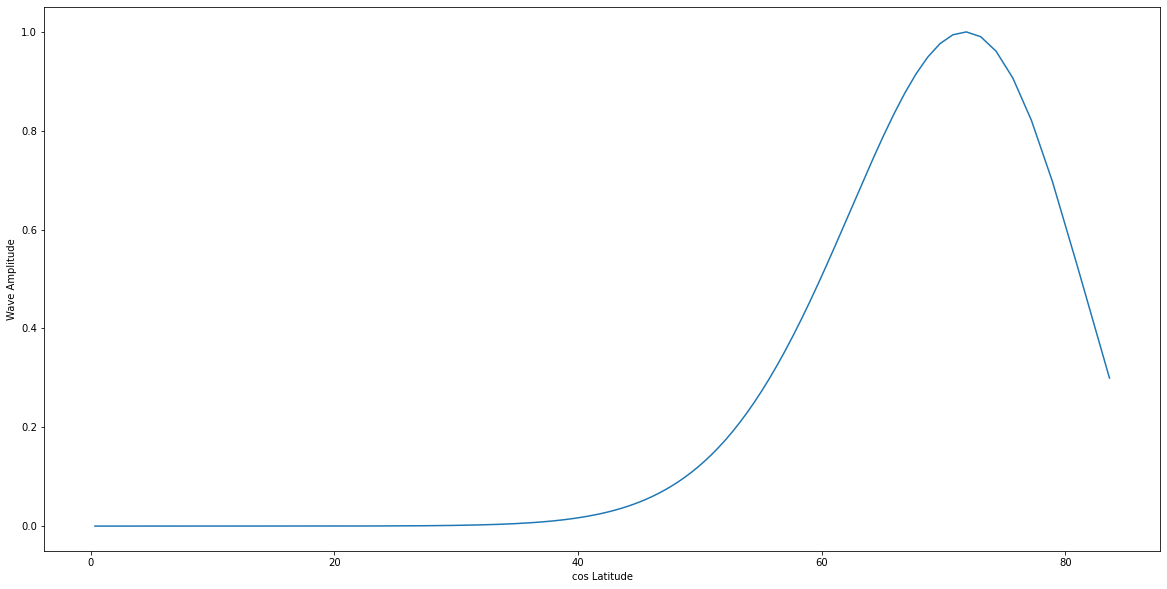

In [55]:
A=setA(ngrid,m,M)
omega,bysec = modes_y(A,C0)
y = sety(ngrid)

pd = 2 * np.pi / (sectoyear * np.real(omega)); print("Period : %.1f years"%pd)
q = np.abs(0.5*np.real(omega)/np.imag(omega)); print("Quality factor : %.2f"%q)


lat = np.arcsin(y)*180.0/np.pi

# Code to plot the eigenvector corresponding to the closest eigenvalue
_,ax=plt.subplots(1,1,figsize=(20,10))
by = bysec[:ngrid]/(1-y**2)
amp = np.max(np.abs(np.real(by)));
ax.plot(lat,np.abs(np.real(by))/amp)
ax.set_xlabel("cos Latitude")
ax.set_ylabel("Wave Amplitude")
plt.show()



## Code to plot the matrix A
#_,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
#p1 = ax1.matshow(np.log10(np.abs(np.real(A))))
#plt.colorbar(p1,ax=ax1);ax1.set_title("log10(real(A))")
#p2 = ax2.matshow(np.log10(np.abs(np.imag(A))))
#plt.colorbar(p2,ax=ax2);ax2.set_title("log10(imag(A))")
#plt.show()